# Spotify Hit Predictor
by: Aiman Madan

## Imported Libraries 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


## Dataset
This is a dataset consisting of features for tracks fetched using Spotify's Web API.

In [64]:
df_2000s = pd.read_csv('/home/madan005/dev/MusicProject/dataset-of-00s.csv')
df_2010s = pd.read_csv('/home/madan005/dev/MusicProject/dataset-of-10s.csv')
df = pd.concat([df_2000s, df_2010s], ignore_index=True) # Merge multiple DataFrame objects along a thier shared column
df.drop(columns=['uri','target'], inplace=True)
df.head()

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections
0,Lucky Man,Montgomery Gentry,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,13
1,On The Hotline,Pretty Ricky,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,10
2,Clouds Of Dementia,Candlemass,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,13
3,"Heavy Metal, Raise Hell!",Zwartketterij,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,9
4,I Got A Feelin',Billy Currington,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,10


In [ ]:
#Apply Label Encoding to the 'artist' column
label_encoder = LabelEncoder()
df['artist_encoded'] = label_encoder.fit_transform(df['artist'])
df['track_encoded'] = label_encoder.fit_transform(df['track'])

# normalize
features = ['danceability', 'energy', 'tempo', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'artist_encoded','track_encoded', 'chorus_hit', 'sections', 'duration_ms', 'mode', 'key', 'time_signature']

# Apply Min-Max Scaling
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


df.head()

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,artist_encoded,track_encoded
0,Lucky Man,Montgomery Gentry,0.559965,0.471339,0.363636,0.826531,1.0,0.006962,0.369478,0.000000,0.146656,0.541752,0.538881,0.043518,0.8,0.117589,0.071429,0.619040,0.514192
1,On The Hotline,Pretty Ricky,0.695858,0.854818,0.909091,0.863528,0.0,0.172022,0.018574,0.000000,0.135319,0.700611,0.308396,0.054562,0.8,0.158068,0.053571,0.709469,0.611798
2,Clouds Of Dementia,Candlemass,0.111303,0.836796,0.818182,0.914452,1.0,0.026671,0.000111,0.004579,0.162115,0.305499,0.273748,0.077744,0.8,0.248763,0.071429,0.152589,0.161224
3,"Heavy Metal, Raise Hell!",Zwartketterij,0.139344,0.994994,0.363636,0.899265,1.0,0.153813,0.000007,0.078557,0.180666,0.339104,0.627335,0.057710,0.8,0.223122,0.047619,0.992337,0.347095
4,I Got A Feelin',Billy Currington,0.616048,0.764706,0.181818,0.886720,1.0,0.005463,0.364458,0.000000,0.111615,0.642566,0.418310,0.042809,0.8,0.086148,0.053571,0.103883,0.384554


In [ ]:

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Train Autoencoder to learn embeddings
pca = PCA(n_components=10)  
embeddings = pca.fit_transform(scaled_features)

# Compute cosine similarity on learned embeddings
similarity_matrix = cosine_similarity(embeddings)


def recommend_songs_ml(song_name, df, matrix, top_n=5):

    # Find the index of the song
    try:
        song_idx = df[df['track'] == song_name].index[0]
    except IndexError:
        return f"Song '{song_name}' not found in the dataset."

    # Print input song
    print(f"Input Song:\nTrack: {song_name}\nArtist: {df.iloc[song_idx]['artist']}\n")

    # Get similarity scores for the song
    similarity_scores = list(enumerate(matrix[song_idx]))

    # Sort by similarity scores in descending order
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top_n most similar songs
    recommended_indices = [i[0] for i in similarity_scores[1:top_n + 1]]

    # Get recommended songs
    recommendations = df.iloc[recommended_indices][['track', 'artist']]

    return recommendations

# Recommend songs
recommendations = recommend_songs_ml("In Da Club", df, similarity_matrix)

# Check if the output is a DataFrame
if isinstance(recommendations, pd.DataFrame):
    recommendations.reset_index(drop=True, inplace=True)
    print("Recommended Songs:")
    print(recommendations)
else:
    print(recommendations)


Input Song:
Track: In Da Club
Artist: 50 Cent

Recommended Songs:
                                track                               artist
0                          Look Alive           BlocBoy JB Featuring Drake
1                Ma, I Don't Love Her         Clipse Featuring Faith Evans
2  I Just Wanna Love U (Give It 2 Me)                                JAY-Z
3                          Open House                                 Guru
4                        It's So Hard  Big Punisher Featuring Donell Jones


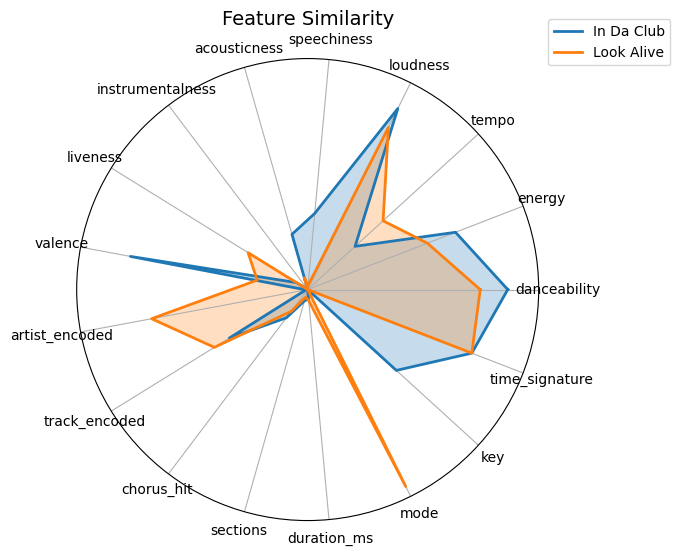

In [ ]:

def plot_feature_similarity(song_name, recommended_song, df, features):
    input_song = df[df['track'] == song_name].iloc[0]
    recommended_song_data = df[df['track'] == recommended_song].iloc[0]

    labels = features
    input_values = input_song[features].values
    recommended_values = recommended_song_data[features].values

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    input_values = np.concatenate((input_values, [input_values[0]]))
    recommended_values = np.concatenate((recommended_values, [recommended_values[0]]))

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, input_values, label=song_name, linewidth=2)
    ax.plot(angles, recommended_values, label=recommended_song, linewidth=2)
    ax.fill(angles, input_values, alpha=0.25)
    ax.fill(angles, recommended_values, alpha=0.25)
    ax.set_yticks([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.title("Feature Similarity", fontsize=14)
    plt.show()


plot_feature_similarity("In Da Club", recommendations.iloc[0]['track'], df, features)


In [68]:
# Recommends songs based on learned embeddings and cosine similarity, using multiple input songs.

def recommend_songs(user_songs, df, matrix, top_n=5):

    # Find the indices of the songs in the user's list
    song_indices = []
    for song in user_songs:
        try:
            song_indices.append(df[df['track'] == song].index[0])
        except IndexError:
            print(f"Song '{song}' not found in the dataset.")

    if not song_indices:
        return "No valid songs found in the dataset."

    # Print the input songs
    print("Input Songs:")
    for song in user_songs:
        if song in df['track'].values:
            artist = df[df['track'] == song]['artist'].iloc[0]
            print(f"Track: {song}, Artist: {artist}")
        else:
            print(f"Track: {song}, Artist: Not Found")
    print()

    # Compute the mean of the user songs' similarity scores
    aggregated_scores = sum(matrix[i] for i in song_indices) / len(song_indices)

    # Get similarity scores for all songs
    similarity_scores = list(enumerate(aggregated_scores))

    # Sort by similarity scores in descending order
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top_n most similar songs, excluding the input songs
    recommended_indices = [
        i[0] for i in similarity_scores if i[0] not in song_indices
    ][:top_n]

    # Return the track names and artists of the recommended songs
    return df.iloc[recommended_indices][['track', 'artist']]

# Example usage with multiple songs
user_songs = ["The Real Slim Shady", "Funhouse", "Goosebumps"]
recommendations = recommend_songs(user_songs, df, similarity_matrix)

# Check if the output is a DataFrame
if isinstance(recommendations, pd.DataFrame):
    recommendations.reset_index(drop=True, inplace=True)
    print("\nRecommended Songs:")
    print(recommendations)
else:
    print(recommendations)


Input Songs:
Track: The Real Slim Shady, Artist: Eminem
Track: Funhouse, Artist: P!nk
Track: Goosebumps, Artist: Travis Scott


Recommended Songs:
               track                                           artist
0          Entourage                                          Omarion
1     I Need To Know                                     Marc Anthony
2               Only                                  Nine Inch Nails
3   Hole In The Head                                        Sugababes
4  I've Been Waiting  Lil Peep & iLoveMakonnen Featuring Fall Out Boy


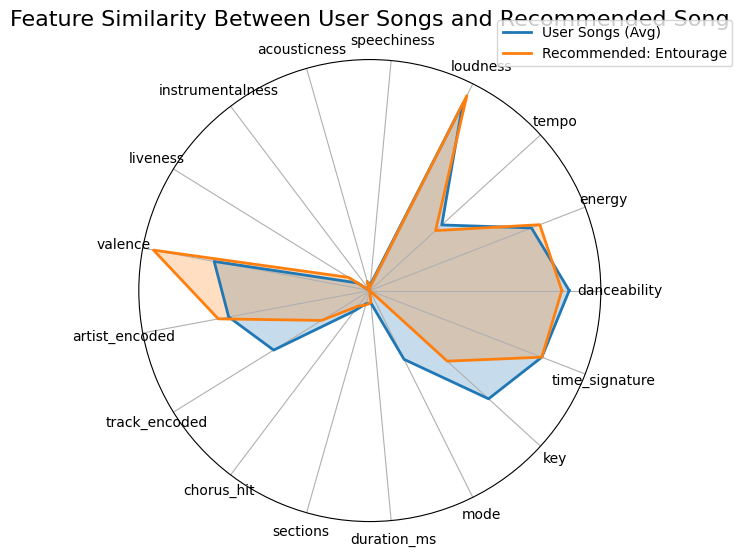

In [ ]:

def plot_feature_similarity(user_songs, recommended_song, df, numerical_features):
    
    # Get the data for the user songs and compute their average feature values
    input_songs_data = df[df['track'].isin(user_songs)]
    if input_songs_data.empty:
        print("No valid input songs found in the dataset.")
        return
    
    input_values = input_songs_data[numerical_features].mean().values
    recommended_song_data = df[df['track'] == recommended_song]
    if recommended_song_data.empty:
        print(f"Recommended song '{recommended_song}' not found in the dataset.")
        return

    recommended_values = recommended_song_data.iloc[0][numerical_features].values

    # Labels for the radar chart
    labels = numerical_features
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]  # Close the radar chart

    # Close the radar chart data by appending the first value
    input_values = np.concatenate((input_values, [input_values[0]]))
    recommended_values = np.concatenate((recommended_values, [recommended_values[0]]))

    # Create the radar chart
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, input_values, label="User Songs (Avg)", linewidth=2)
    ax.plot(angles, recommended_values, label=f"Recommended: {recommended_song}", linewidth=2)
    ax.fill(angles, input_values, alpha=0.25)
    ax.fill(angles, recommended_values, alpha=0.25)

    # Configure the chart
    ax.set_yticks([])  # Remove radial grid labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10)
    plt.title("Feature Similarity Between User Songs and Recommended Song", fontsize=16)
    plt.show()

# Example: Plot similarity for the first recommendation
if isinstance(recommendations, pd.DataFrame):
    plot_feature_similarity(user_songs, recommendations.iloc[0]['track'], df, features)
else:
    print("Recommendations are not available.")
